# Digital Elevation Map to 3D CAD File

In [1]:
from cadquery import exporters
import time
import numpy as np
import rioxarray
import matplotlib.pyplot as plt
import matplotlib

from topocad import haversine, get_xz, make_topo_cad, coarsen

In [2]:
# 1/3 arc-second (approx. 10m) DEM is from USGS: https://apps.nationalmap.gov/downloader/

fp = '/Users/grantbuster/Downloads/USGS_13_n40w106_20230602.tif'
dset1 = rioxarray.open_rasterio(fp, decode_coords='all').to_dataset('band')

fp = '/Users/grantbuster/Downloads/USGS_13_n41w106_20230314.tif'
dset2 = rioxarray.open_rasterio(fp, decode_coords='all').to_dataset('band')

In [3]:
mask = ~(dset2.y.values < dset1.y.values[0])  # tile overlap
full_arr = np.vstack((dset2[1].values[mask], dset1[1].values))
full_x = dset1.x.values
full_y = np.hstack((dset2.y.values[mask], dset1.y.values))

In [4]:
# Boulder, CO
lat_range = (39.93, 40.084)
lon_range = (-105.40, -105.20)

In [5]:
coarsen_factor = 10  # reduce this to 3-5 for high-detail final model creation

idx = (full_x > np.min(lon_range)) & (full_x < np.max(lon_range))
idy = (full_y > np.min(lat_range)) & (full_y < np.max(lat_range))
arr = full_arr[idy][:, idx]
x = full_x[idx]
y = full_y[idy]
arr = coarsen(arr, coarsen_factor)
dx = haversine((y[0], x[0]), (y[0], x[-1]))
dy = haversine((y[0], x[0]), (y[-1], x[0]))
dx, dy

(17.007210646907897, 17.11166358797671)

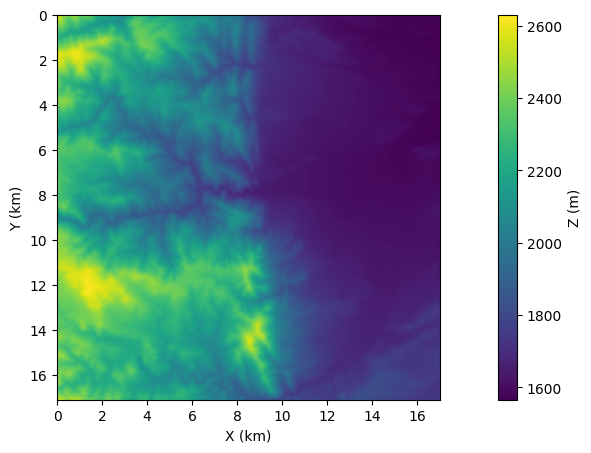

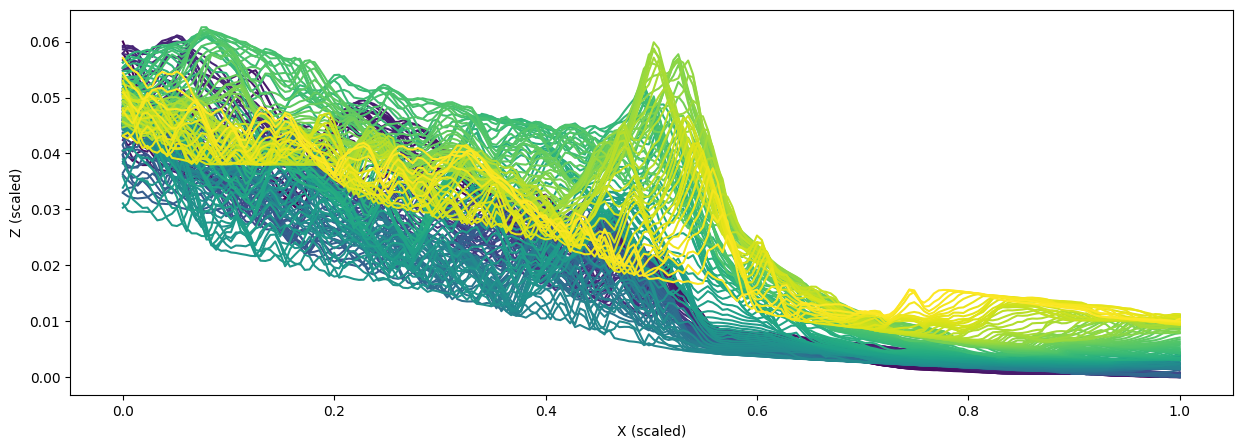

In [6]:
# Make a simple matplotlib 2D views

fig, ax = plt.subplots(1, 1, figsize=(15, 5))
a = ax.imshow(arr, extent=(0, dx, dy, 0))
plt.colorbar(a, ax=ax, label='Z (m)')
ax.set_ylabel('Y (km)')
ax.set_xlabel('X (km)')
plt.show()
plt.close()

fig, ax = plt.subplots(1, 1, figsize=(15, 5))
irows = np.arange(0, len(arr), 1)
cmap = matplotlib.colormaps['viridis']
for irow in irows:
    xz = get_xz(arr, irow, dx, x_scale=1, z_exag=1, z_adder=0)
    ax.plot([ixz[0] for ixz in xz],
                 [ixz[1] for ixz in xz], c=cmap(irow/irows.max()))
    
ax.set_ylabel('Z (scaled)')
ax.set_xlabel('X (scaled)')
plt.show()
plt.close()

In [7]:
t0 = time.time()
wp, ppm, aspect = make_topo_cad(arr, dx, dy, x_scale=100, z_exag=1, z_adder=0.5, subsample=1, spline=False)
t1 = time.time()
print('Model took {:.3f} minutes to make. '
      'Approximately {:.1f} points per mm. '
      'Aspect ratio (x:y) is {}'
      .format((t1 - t0) / 60, ppm, aspect))

Model took 0.370 minutes to make. Approximately 2.2 points per mm. Aspect ratio (x:y) is 100:101


In [8]:
display(wp)
exporters.export(wp, "./test.stl")